<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import warnings
import itertools
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, ParameterGrid
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    print("При загрузке файла возникли ошибки")

In [3]:
data.sort_index(inplace=True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
data.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [7]:
data.index.is_monotonic

True

In [8]:
data = data.resample('1H').sum()
#data
display(data.head())
display(data.tail())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


<b>Вывод</b>

Данные загружены, индекс монотонный, выполнено ресеплирование по 1 часу. В выборке представлены данные за период 6 месяцев с марта по август 2018.

## Анализ

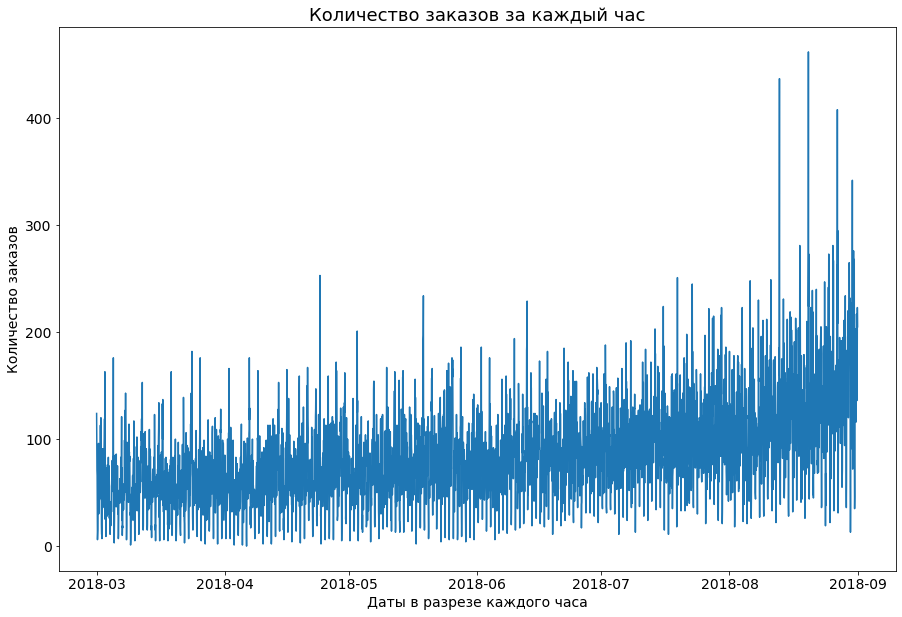

In [9]:
plt.figure(figsize=(15, 10))
plt.plot(data)
plt.xlabel('Даты в разрезе каждого часа', fontsize=14)
plt.ylabel('Количество заказов', fontsize=14)
plt.title('Количество заказов за каждый час', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Данные очень валатильные, построим скользящее среднее.

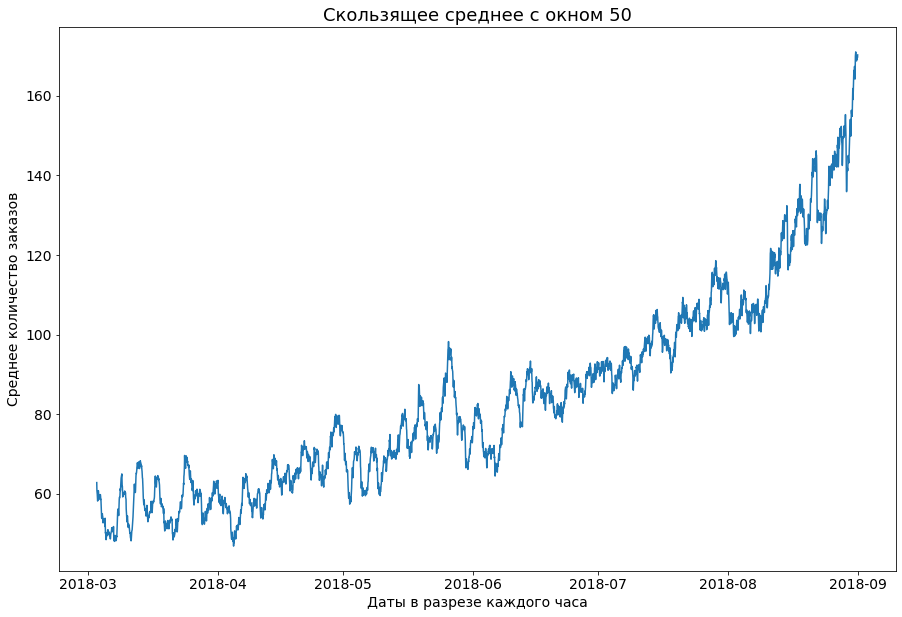

In [11]:
plt.figure(figsize=(15, 10))
plt.plot(data.shift().rolling(50).mean())
plt.xlabel('Даты в разрезе каждого часа', fontsize=14)
plt.ylabel('Среднее количество заказов', fontsize=14)
plt.title('Скользящее среднее с окном 50', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

 За указанные период, среднее количество заказов устойчиво растет.

Разложим график на составляющие.

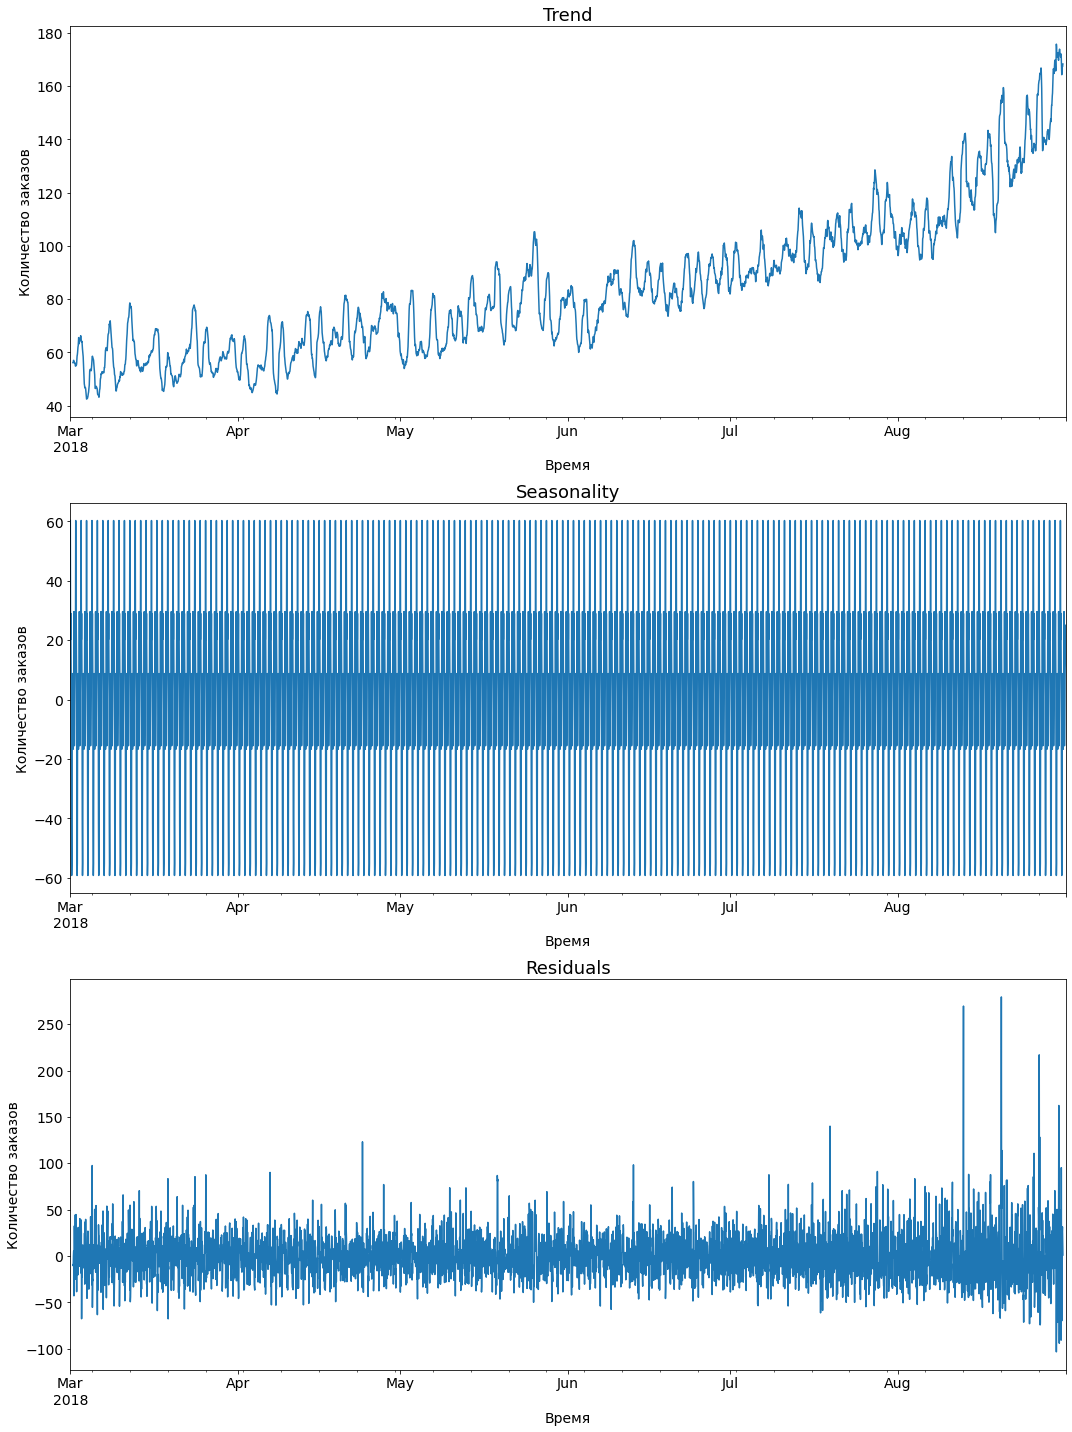

In [12]:
decomposed = seasonal_decompose(data) 

plt.figure(figsize=(15, 20))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.xlabel('Время', fontsize=14)  
plt.ylabel('Количество заказов', fontsize=14) 
plt.title('Trend', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality', fontsize=18)
plt.xlabel('Время', fontsize=14)  
plt.ylabel('Количество заказов', fontsize=14) 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals', fontsize=18)
plt.xlabel('Время', fontsize=14)  
plt.ylabel('Количество заказов', fontsize=14) 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

Проанализируем график за период 15 дней

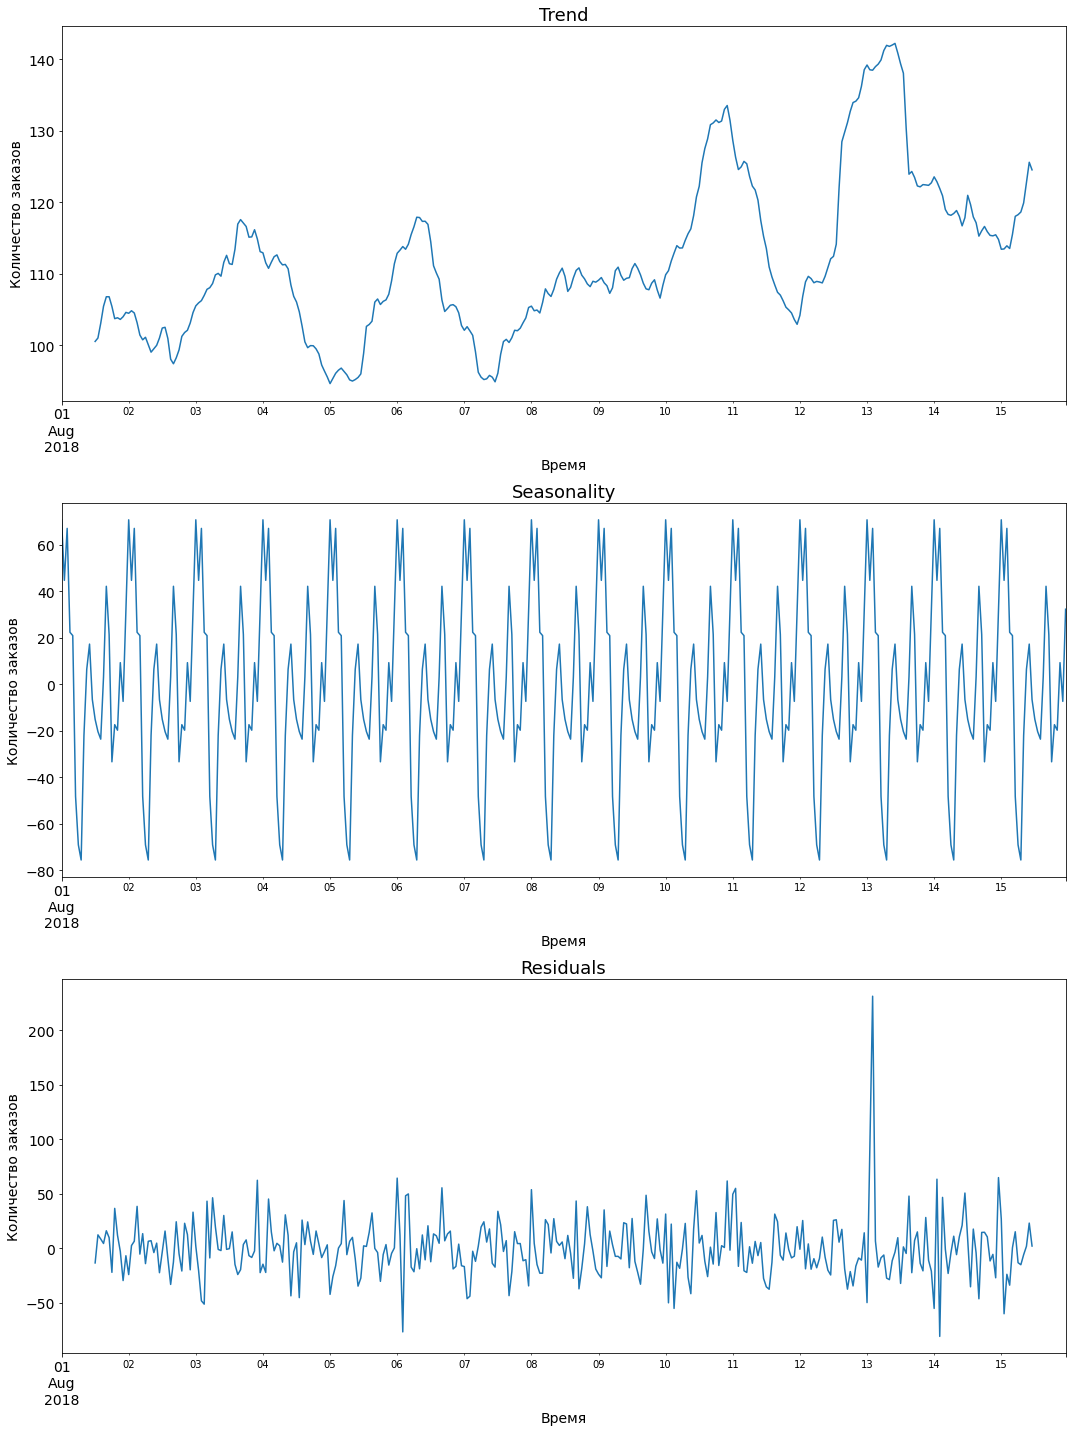

In [13]:
decomposed = seasonal_decompose(data['2018-08-01':'2018-08-15']) 

plt.figure(figsize=(15, 20))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.xlabel('Время', fontsize=14)  
plt.ylabel('Количество заказов', fontsize=14) 
plt.title('Trend', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality', fontsize=18)
plt.xlabel('Время', fontsize=14)  
plt.ylabel('Количество заказов', fontsize=14) 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals', fontsize=18)
plt.xlabel('Время', fontsize=14)  
plt.ylabel('Количество заказов', fontsize=14) 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

Из графиков можно сделать вывод, что ночнью минимальное количество заказов, а пик - в вечернее время. Также наблюдается повышенный спрос на такси по четвергам и субботам.

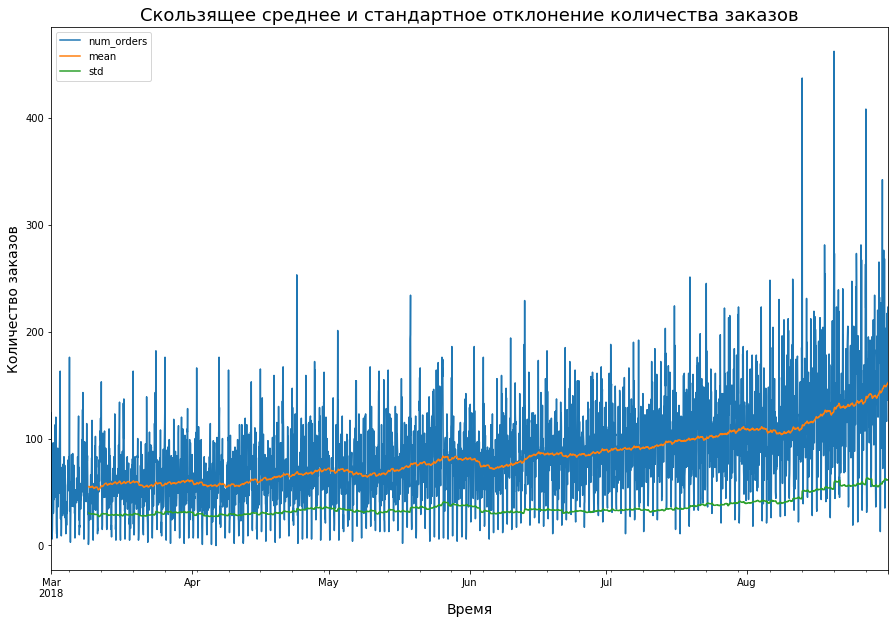

In [14]:
data['mean'] = data['num_orders'].rolling(200).mean()
data['std'] = data['num_orders'].rolling(200).std()
data.plot(figsize=(15, 10))
plt.xlabel('Время', fontsize=14)  
plt.ylabel('Количество заказов', fontsize=14)  
plt.title('Скользящее среднее и стандартное отклонение количества заказов', fontsize=18)  
plt.show()


Из графика видем, что данны временной ряд не стационарный, так среднее истандартное отклонение увеличивается со временем. Преобразуем в стационарный ряд.

In [15]:
result = adfuller(data['num_orders'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

alpha = '1%'
if result[0] < result[4][alpha]:
    print(f"Временной ряд стационарен на уровне значимости {alpha}.")
else:
    print(f"Временной ряд не стационарен на уровне значимости {alpha}.")
    
alpha = '5%'
if result[0] < result[4][alpha]:
    print(f"Временной ряд стационарен на уровне значимости {alpha}.")
else:
    print(f"Временной ряд не стационарен на уровне значимости {alpha}.")

ADF Statistic: -3.068924
p-value: 0.028940
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Временной ряд не стационарен на уровне значимости 1%.
Временной ряд стационарен на уровне значимости 5%.


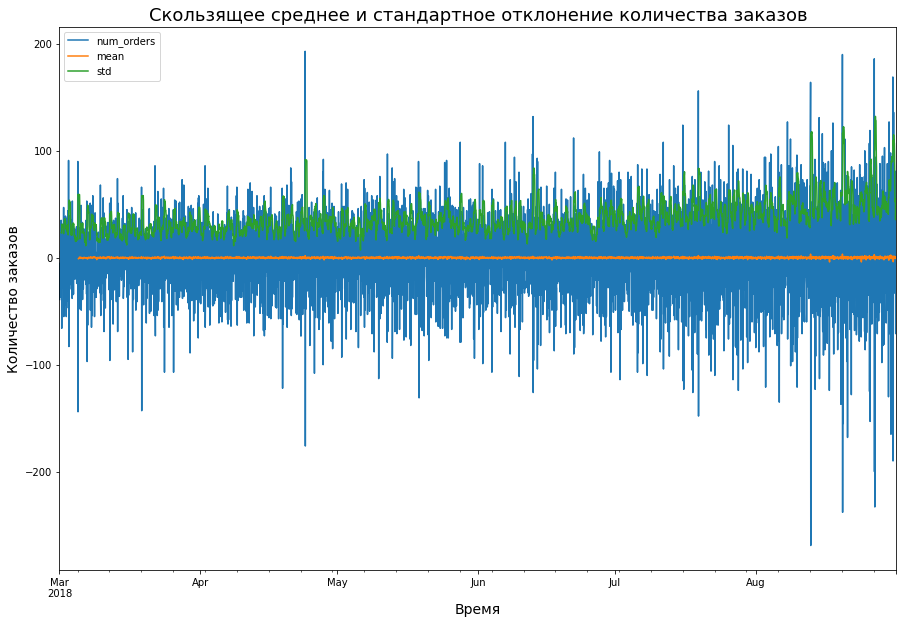

In [16]:
data_shift = data - data.shift()
data_shift['mean'] = data_shift['num_orders'].rolling(100).mean()
data_shift['std'] = data_shift['num_orders'].rolling(10).std()
data_shift.plot(figsize=(15, 10))
plt.xlabel('Время', fontsize=14)  
plt.ylabel('Количество заказов', fontsize=14)  
plt.title('Скользящее среднее и стандартное отклонение количества заказов', fontsize=18)  
plt.show()

<b>Вывод</b>

 - Представленный временной ряд не стационарный, среднее увеличиввается. 
 - Наблюдается внутридневная сезонность - ночью количество заказов падает до минимума и у возврастает до максимума в вечернее время.
 - Наблюдается увелечение заказаов по четвергам и субботам.

## Обучение

In [17]:
warnings.filterwarnings('ignore')

Создадим функцию для создания признаков.

In [19]:
def make_features(data, max_lag, rolling_mean_size):
    data_features = data.copy()
    data_features['day'] = data_features.index.day
    data_features['dayofweek'] = data_features.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_features['lag_{}'.format(lag)] = data_features['num_orders'].shift(lag)

    data_features['rolling_mean'] = data_features['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_features

установим max_lag = 24 (потому что у нас данные за каждый час), а rolling_mean_size = 168 (чтобы среднее высчитывалось за неделю)

In [20]:
data_features = make_features(data, 24, 168)

In [21]:
train, test = train_test_split(data_features, shuffle=False, test_size=0.1, random_state=42)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Расчитаем RMSE для простой модели линейное регрессии

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)
model_lr = LinearRegression()
param_grid = {
    'normalize': [True, False],
    'fit_intercept': [True, False]
}

In [23]:
grid_search_lr = GridSearchCV(model_lr, param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search_lr.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring='neg_mean_squared_error')

In [24]:
print("Лучшие параметры LinearRegression:", grid_search_lr.best_params_)
print("Лучшая оценка RMSE для LinearRegression:",  sqrt(-grid_search_lr.best_score_))

Лучшие параметры LinearRegression: {'fit_intercept': False, 'normalize': True}
Лучшая оценка RMSE для LinearRegression: 27.251417097556565


Попробуем улучшить метрику используя модель LightGBM и перебор гиперпараметров.

In [25]:
model_lgb = lgb.LGBMRegressor(random_state=42)

In [26]:
tscv = TimeSeriesSplit(n_splits=5)

In [27]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_samples': [10, 20, 30],
    'num_leaves': [30, 40, 50],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}
grid_search_lgb = GridSearchCV(model_lgb, param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search_lgb.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(random_state=42),
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'min_child_samples': [10, 20, 30],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [30, 40, 50],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='neg_mean_squared_error')

In [28]:
print("Лучшие параметры LGBM:", grid_search_lgb.best_params_)
print("Лучшая оценка RMSE для LGBM:",  sqrt(-grid_search_lgb.best_score_))

Лучшие параметры LGBM: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 10, 'n_estimators': 100, 'num_leaves': 40, 'subsample': 0.8}
Лучшая оценка RMSE для LGBM: 25.980921213339233


<b>Вывод</b>

Было обучено две модели с перебором гиперпараметров:
- LinearREgression, Лучшая метрика RMSE на валидации: 27.25
- LGBMRegressor, Лучшая метрика RMSE на валидации: 25.98

## Тестирование

Определим метрику RMSE для проверки модели на адекватность.

In [29]:
print("Среднее количество заказов в час:", test['num_orders'].mean())
pred_rmse = mean_squared_error(test['num_orders'], np.ones(test['num_orders'].shape[0]) * train['num_orders'].mean(), squared=False)
print("RMSE baseline:", pred_rmse)

Среднее количество заказов в час: 139.55656108597285
RMSE baseline: 83.87390163848711


Протестируем лучшую модель LGBM на тестовых данных

In [30]:
best_model = grid_search_lgb.best_estimator_
test_pred = best_model.predict(features_test)
rmse = mean_squared_error(target_test, test_pred, squared=False)
print("RMSE лучшей модели LightGBM  на тестовых данных:", rmse)

RMSE лучшей модели LightGBM  на тестовых данных: 41.19027230467655


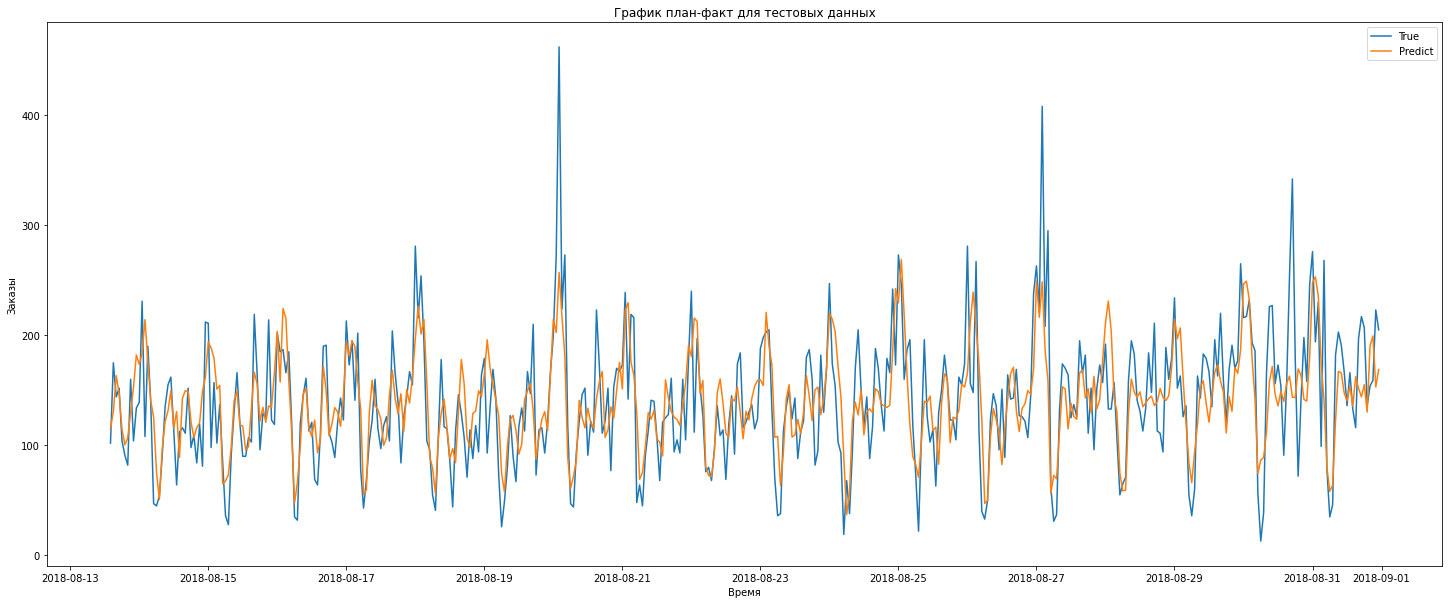

In [37]:
plt.figure(figsize=(25, 10))
plt.plot(target_test, label='True')
plt.plot(target_test.index, test_pred, label='Predict')
plt.legend()
plt.xlabel('Время')
plt.ylabel('Заказы')
plt.title('График план-факт для тестовых данных')
plt.show()

Модель неплохо определяет общий тренд и внутридневную сезонность, но плохо справляется с экстремальными (пиковыми) значениями.

<b>Вывод</b>

Модель LightGBM показала на тестовых данных гораздо лучшую метрику RMSE по сравнению с baseline: 41.19 против 73. Но при этом модель получилась переобученной, т.к. на валидационных данных был достигнут 26.